In [2]:
import numpy as np
import random
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
import torch
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils import resample

/home/darrentimotius/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Common functions
LABEL2INDEX = {'positive': 0, 'neutral': 1, 'negative': 2}
INDEX2LABEL = {0: 'positive', 1: 'neutral', 2: 'negative'}
NUM_LABELS = 3

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [4]:
# Set random seed
set_seed(20250702)

### Load Model

In [5]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Prepare Dataset

In [6]:
# Processing Datasets
def load_dataset(path):
    df = pd.read_csv(path, sep='\t', header=None)
    df.columns = ['text', 'sentiment']
    df['sentiment'] = df['sentiment'].apply(lambda lab: LABEL2INDEX[lab])
    return df

def encode_dataset(df, tokenizer, no_special_token=False):
    encoded = []
    for _, row in df.iterrows():
        text = row['text']
        sentiment = row['sentiment']
        subwords = tokenizer.encode(text, add_special_tokens=not no_special_token)
        encoded.append((np.array(subwords), np.array(sentiment), text))
    return encoded

def collate_fn(batch, max_seq_len=512):
    batch_size = len(batch)
    max_len = min(max(len(x[0]) for x in batch), max_seq_len)
    
    subword_batch = np.zeros((batch_size, max_len), dtype=np.int64)
    mask_batch = np.zeros((batch_size, max_len), dtype=np.float32)
    sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)
    seq_list = []

    for i, (subwords, sentiment, raw_seq) in enumerate(batch):
        subwords = subwords[:max_len]
        subword_batch[i, :len(subwords)] = subwords
        mask_batch[i, :len(subwords)] = 1
        sentiment_batch[i, 0] = sentiment
        seq_list.append(raw_seq)

    return (
        torch.tensor(subword_batch),
        torch.tensor(mask_batch),
        torch.tensor(sentiment_batch),
        seq_list
    )

In [8]:
train_dataset_path = '../data/smsa/train_preprocess.tsv'
valid_dataset_path = '../data/smsa/valid_preprocess.tsv'
test_dataset_path = '../data/smsa/test_preprocess.tsv'
test_labeling_path = '../data/smsa/test_preprocess_masked_label.tsv'

In [9]:
train_df = load_dataset(train_dataset_path)
valid_df = load_dataset(valid_dataset_path)
test_df  = load_dataset(test_dataset_path)
test_label_df = load_dataset(test_labeling_path)

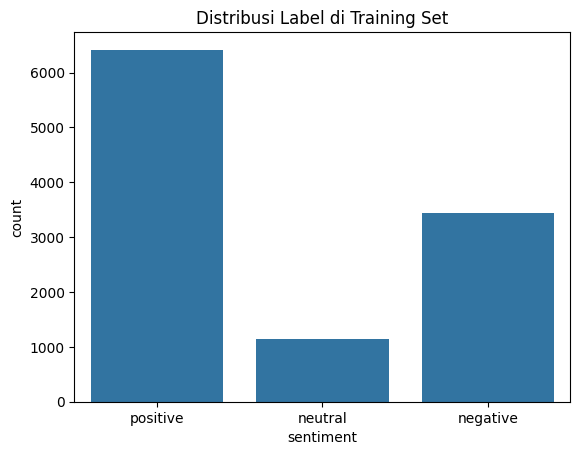

In [10]:
# Distribution label
data = train_df
data['sentiment'] = data['sentiment'].apply(lambda lab: INDEX2LABEL[lab])
sns.countplot(data, x='sentiment')
plt.title("Distribusi Label di Training Set")
plt.show()

In [11]:
train_encoded = encode_dataset(train_df, tokenizer)
valid_encoded = encode_dataset(valid_df, tokenizer)
test_encoded  = encode_dataset(test_df, tokenizer)
test_label_encoded = encode_dataset(test_label_df, tokenizer)

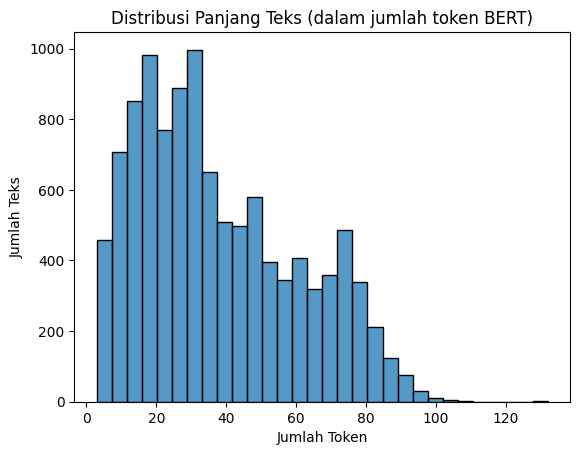

In [10]:
train_df['token_count'] = train_df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))
sns.histplot(train_df['token_count'], bins=30)
plt.title("Distribusi Panjang Teks (dalam jumlah token BERT)")
plt.xlabel("Jumlah Token")
plt.ylabel("Jumlah Teks")
plt.show()

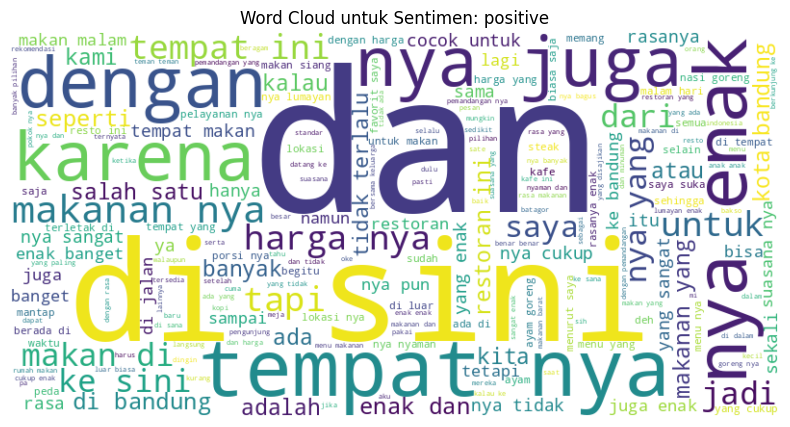

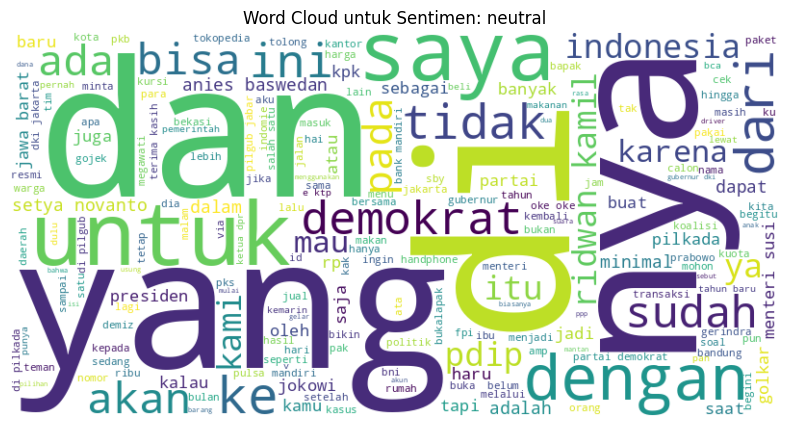

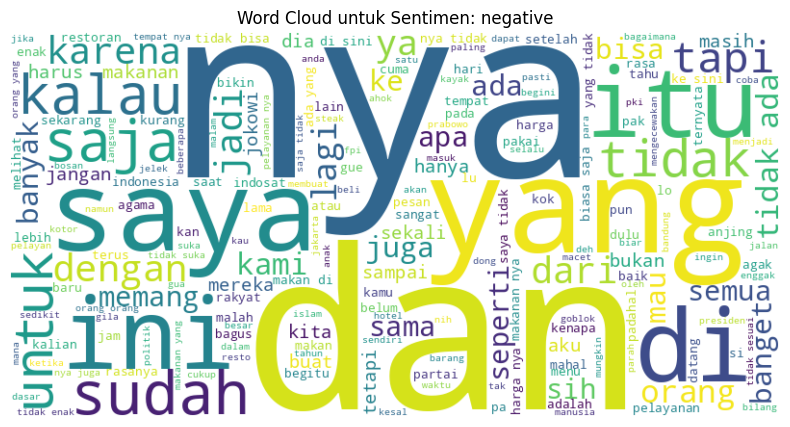

In [11]:
for label in LABEL2INDEX:
    subset = train_df[train_df['sentiment'] == LABEL2INDEX[label]]
    text = ' '.join(subset['text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud untuk Sentimen: {label}')
    plt.show()

In [12]:
train_loader = DataLoader(
    train_encoded, batch_size=32, shuffle=True, num_workers=8,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

valid_loader = DataLoader(
    valid_encoded, batch_size=32, shuffle=False, num_workers=8,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

test_loader = DataLoader(
    test_encoded, batch_size=32, shuffle=False, num_workers=8,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

test_label_loader = DataLoader(
    test_label_encoded, batch_size=32, shuffle=False, num_workers=8,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

In [16]:
w2i, i2w = LABEL2INDEX, INDEX2LABEL
print(w2i)
print(i2w)

train_df

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


,text,sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


### Fine tuning and evaluation

In [14]:
optimizer = optim.Adam(model.parameters(), lr=5e-6)
model = model.cpu()

In [17]:
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu'):
    """
    Forward function for sequence classification.
    
    Parameters:
        model      : torch.nn.Module
        batch_data : tuple of (input_ids, attention_mask, [token_type_ids], labels)
        i2w        : dict, index to label mapping
        is_test    : bool, whether test mode (optional)
        device     : str or torch.device
    
    Returns:
        loss       : torch.Tensor
        list_hyp   : list of predicted labels
        list_label : list of ground truth labels
    """
    
    # Move data to tensors
    if len(batch_data) == 3:
        input_ids, attention_mask, labels = batch_data
        token_type_ids = None
    else:
        input_ids, attention_mask, token_type_ids, labels = batch_data
    
    input_ids = torch.as_tensor(input_ids).to(device)
    attention_mask = torch.as_tensor(attention_mask).to(device)
    labels = torch.as_tensor(labels).to(device)
    
    if token_type_ids is not None:
        token_type_ids = torch.tensor(token_type_ids).to(device)

    # Forward pass
    outputs = model(
        input_ids, 
        attention_mask=attention_mask, 
        token_type_ids=token_type_ids, 
        labels=labels
    )
    loss, logits = outputs[:2]

    # Get predictions
    preds = torch.argmax(logits, dim=1)
    
    list_hyp = [i2w[p.item()] for p in preds]
    list_label = [i2w[l.item()] for l in labels]

    return loss, list_hyp, list_label

def document_sentiment_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics

In [ ]:
# Training model
n_epochs = 8
train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device='cpu'
        )

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss += tr_loss

        # Track predictions
        list_hyp += batch_hyp
        list_label += batch_label

        current_lr = optimizer.param_groups[0]['lr']
        train_pbar.set_description(
            f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss/(i+1):.4f} LR:{current_lr:.8f}"
        )

    # Train metrics
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss/(i+1):.4f} {metrics_to_string(metrics)} "
        f"LR:{current_lr:.8f}")
    avg_train_loss = total_train_loss / (i + 1)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss = 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device='cpu'
        )

        total_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

        metrics = document_sentiment_metrics_fn(list_hyp, list_label)
        pbar.set_description(
            f"VALID LOSS:{total_loss/(i+1):.4f} {metrics_to_string(metrics)}"
        )

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) VALID LOSS:{total_loss/(i+1):.4f} {metrics_to_string(metrics)}")
    avg_valid_loss = total_loss / (i + 1)
    valid_losses.append(avg_valid_loss)

In [103]:
# Got from Google's Colab Training with CUDA (8 Epoch)
train_losses = [0.2967228440697803, 0.13494487632564162, 0.09495903173634826, 0.06122404889360633, 0.040144666410755196, 0.026050692655316683, 0.01853573018093431, 0.01306567119324829]

valid_losses = [0.1883978292811662, 0.17104967609047889, 0.15963366703363135, 0.18878897572285497, 0.22616395293734967, 0.2477362641642685, 0.2620969671741477, 0.2950315877591493]

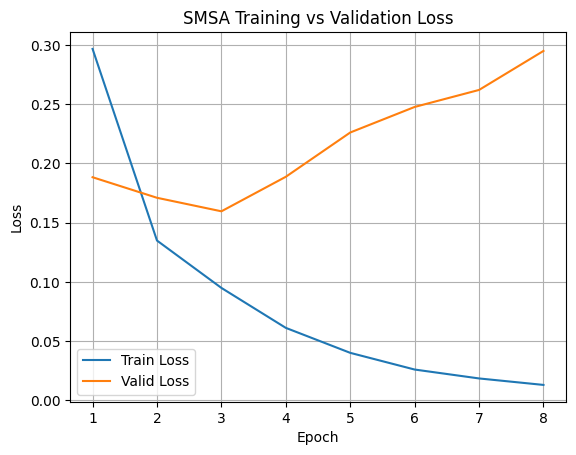

In [40]:
# plt.plot(train_losses, label='Train Loss')
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
# plt.plot(valid_losses, label='Valid Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid Loss')
plt.title("SMSA Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [126]:
# Evaluate on test
accuracies = []
f1_scores = []
model_paths = [
    "../backend/model/smsa/smsa-model-1.pt",
    "../backend/model/smsa/smsa-model-2.pt",
    "../backend/model/smsa/smsa-model-3.pt",
    "../backend/model/smsa/smsa-model-4.pt",
    "../backend/model/smsa/smsa-model-5.pt",
    "../backend/model/smsa/smsa-model-6.pt",
    "../backend/model/smsa/smsa-model-7.pt",
    "../backend/model/smsa/smsa-model-8.pt"
]

i = 0
for path in model_paths:
    i += 1
    model.load_state_dict(torch.load(path, map_location='cpu'))
    model.eval()
    torch.set_grad_enabled(False)

    list_hyp, list_label = [], []

    pbar = tqdm(test_loader, leave=True, total=len(test_loader))
    for _, batch_data in enumerate(pbar):
        _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cpu')
        list_hyp += batch_hyp
        list_label += batch_label

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    accuracies.append(metrics['ACC'])
    f1_scores.append(metrics['F1'])
    print(f"TEST Matrics {i}", end="")
    print(" | {}".format(metrics_to_string(metrics)))

100%|██████████| 16/16 [00:35<00:00,  2.25s/it]


TEST Matrics 1 | ACC:0.90 F1:0.86 REC:0.83 PRE:0.91


100%|██████████| 16/16 [00:35<00:00,  2.23s/it]


TEST Matrics 2 | ACC:0.91 F1:0.88 REC:0.86 PRE:0.92


100%|██████████| 16/16 [00:36<00:00,  2.26s/it]


TEST Matrics 3 | ACC:0.92 F1:0.90 REC:0.89 PRE:0.92


100%|██████████| 16/16 [00:35<00:00,  2.22s/it]


TEST Matrics 4 | ACC:0.92 F1:0.89 REC:0.87 PRE:0.92


100%|██████████| 16/16 [00:35<00:00,  2.22s/it]


TEST Matrics 5 | ACC:0.91 F1:0.87 REC:0.85 PRE:0.93


100%|██████████| 16/16 [00:35<00:00,  2.20s/it]


TEST Matrics 6 | ACC:0.91 F1:0.87 REC:0.85 PRE:0.92


100%|██████████| 16/16 [00:35<00:00,  2.22s/it]


TEST Matrics 7 | ACC:0.91 F1:0.89 REC:0.87 PRE:0.90


100%|██████████| 16/16 [00:36<00:00,  2.27s/it]

TEST Matrics 8 | ACC:0.91 F1:0.88 REC:0.86 PRE:0.91


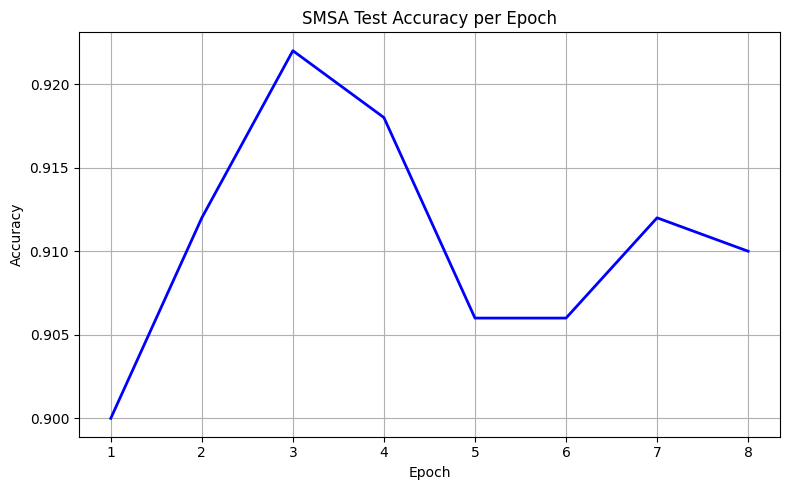

In [127]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies)+1), accuracies, color='blue', linewidth=2)  # grafik garis
plt.title("SMSA Test Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1, len(accuracies)+1))  # biar x axis mulai dari 1
plt.grid(True)
plt.tight_layout()
plt.show()


### Testing model from .csv file and sample sentences using Epoch 3

In [65]:
# Labeling data
model.load_state_dict(torch.load("../backend/model/smsa/smsa-model-3.pt", map_location='cpu'))
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_label_loader, leave=True, total=len(test_label_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cpu')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.csv', index=False)

df

100%|██████████| 16/16 [00:29<00:00,  1.84s/it]


,index,label
0,0,negative
1,1,negative
2,2,negative
3,3,negative
4,4,negative
...,...,...
495,495,neutral
496,496,neutral
497,497,neutral
498,498,positive


In [68]:
# Combine and compare with true
print(test_df.columns)

combined_test_df = test_df
combined_test_df['sentiment'] = combined_test_df['sentiment'].apply(lambda lab: i2w[lab])
combined_test_df['label'] = df['label'].values
combined_test_df.to_csv('../data/output/smsa/combined-test-label.csv', index=False)

Index(['text', 'sentiment', 'label'], dtype='object')


In [69]:
combined_test_df = pd.read_csv('../data/output/smsa/combined-test-label.csv', header=0)
combined_test_df

,text,sentiment,label
0,kemarin gue datang ke tempat makan baru yang a...,negative,negative
1,kayak nya sih gue tidak akan mau balik lagi ke...,negative,negative
2,"kalau dipikir-pikir , sebenarnya tidak ada yan...",negative,negative
3,ini pertama kalinya gua ke bank buat ngurusin ...,negative,negative
4,waktu sampai dengan gue pernah disuruh ibu lat...,negative,negative
...,...,...,...
495,kata nya tidur yang baik itu minimal enam jam ...,neutral,neutral
496,indonesia itu ada di benua asia .,neutral,neutral
497,salah satu kegemaran anak remaja indonesia sek...,neutral,neutral
498,melihat warna hijau bisa bikin mata jadi lebih...,positive,positive


              precision    recall  f1-score   support

    positive       0.91      1.00      0.95       204
     neutral       0.91      0.73      0.81        88
    negative       0.94      0.93      0.93       208

    accuracy                           0.92       500
   macro avg       0.92      0.89      0.90       500
weighted avg       0.92      0.92      0.92       500



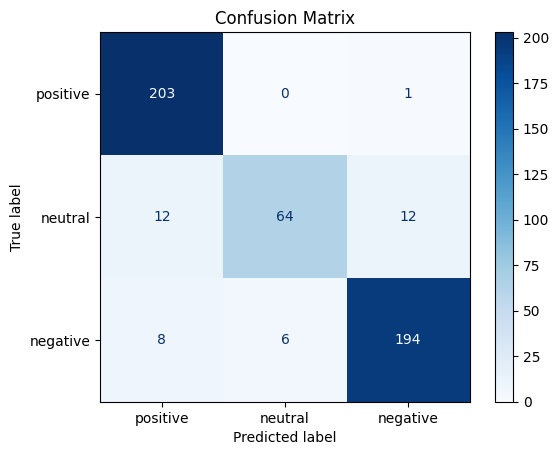

In [70]:
y_true = combined_test_df['sentiment'].tolist()
y_pred = combined_test_df['label'].tolist()

print(classification_report(y_true, y_pred, target_names=INDEX2LABEL.values()))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=INDEX2LABEL.values())
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [71]:
model.load_state_dict(torch.load("../backend/model/smsa/smsa-model-3.pt", map_location='cpu'))
model.eval()
torch.set_grad_enabled(False)

In [72]:
text = 'bagus banget fotonya itu'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bagus banget fotonya itu | Label : positive (99.673%)


In [73]:
text = 'pagi tadi pergi ke BLI'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: pagi tadi pergi ke BLI | Label : neutral (99.070%)


In [74]:
text = 'Dasar anak sialan!! Kurang ajar!!'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Dasar anak sialan!! Kurang ajar!! | Label : negative (99.717%)


### Oversampling Neutral Train Dataset

In [81]:
# DO NOT RUN AGAIN!!!

neutral_df = train_df[train_df['sentiment'] == 'neutral']
positive_df = train_df[train_df['sentiment'] == 'positive']
negative_df = train_df[train_df['sentiment'] == 'negative']

neutral_upsampled = resample(
    neutral_df,
    replace=True,
    n_samples=3500,
    random_state=42
)

balanced_df = pd.concat([positive_df, negative_df, neutral_upsampled])
print(balanced_df['sentiment'].value_counts())

balanced_df.to_csv("balanced-train.tsv", sep='\t', index=False)
balanced_df

sentiment
positive    6416
neutral     3500
negative    3436
Name: count, dtype: int64


,text,sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
5,"makanan beragam , harga makanan di food stall ...",positive
7,"tempat unik , bagus buat foto , makanan enak ,...",positive
...,...,...
8198,daun memiliki berbagai jenis bentuk .,neutral
5336,gerindra merasa tidak ingin mengakui kemenanga...,neutral
6208,toyota mengeluarkan produk terbaru nya .,neutral
5535,ketika terjadi pertentangan antara kontrak pol...,neutral


In [92]:
balanced_df = load_dataset('../data/smsa/balanced-train.tsv')

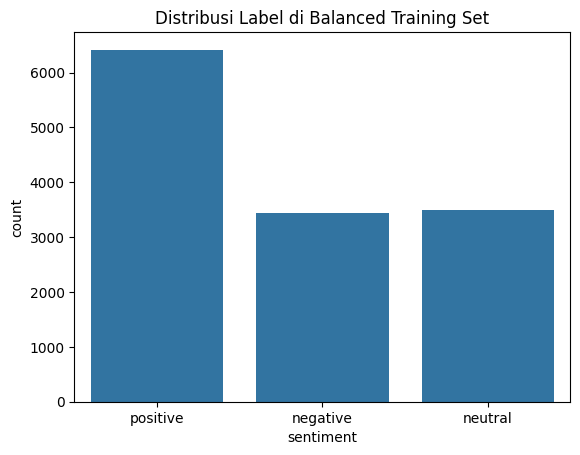

In [86]:
# Distribution label
data = balanced_df
data['sentiment'] = data['sentiment'].apply(lambda lab: INDEX2LABEL[lab])
sns.countplot(data, x='sentiment')
plt.title("Distribusi Label di Balanced Training Set")
plt.show()

In [97]:
balanced_encoded = encode_dataset(balanced_df, tokenizer)

In [98]:
balanced_loader = DataLoader(
    balanced_encoded, batch_size=32, shuffle=True, num_workers=8,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

In [99]:
balanced_df

,text,sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,0
1,lokasi strategis di jalan sumatera bandung . t...,0
2,betapa bahagia nya diri ini saat unboxing pake...,0
3,"makanan beragam , harga makanan di food stall ...",0
4,"tempat unik , bagus buat foto , makanan enak ,...",0
...,...,...
13347,daun memiliki berbagai jenis bentuk .,1
13348,gerindra merasa tidak ingin mengakui kemenanga...,1
13349,toyota mengeluarkan produk terbaru nya .,1
13350,ketika terjadi pertentangan antara kontrak pol...,1


In [ ]:
# Training model
n_epochs = 8
os_train_losses = []
os_valid_losses = []

for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(balanced_loader, leave=True, total=len(balanced_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device='cpu'
        )

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss += tr_loss

        # Track predictions
        list_hyp += batch_hyp
        list_label += batch_label

        current_lr = optimizer.param_groups[0]['lr']
        train_pbar.set_description(
            f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss/(i+1):.4f} LR:{current_lr:.8f}"
        )

    # Train metrics
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss/(i+1):.4f} {metrics_to_string(metrics)} "
        f"LR:{current_lr:.8f}")
    avg_train_loss = total_train_loss / (i + 1)
    os_train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss = 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device='cpu'
        )

        total_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

        metrics = document_sentiment_metrics_fn(list_hyp, list_label)
        pbar.set_description(
            f"VALID LOSS:{total_loss/(i+1):.4f} {metrics_to_string(metrics)}"
        )

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) VALID LOSS:{total_loss/(i+1):.4f} {metrics_to_string(metrics)}")
    avg_valid_loss = total_loss / (i + 1)
    os_valid_losses.append(avg_valid_loss)

In [105]:
os_train_losses = [0.27707407120437, 0.12044387579668295, 0.07358903087604274, 0.04323194892831931, 0.025869611288648117, 0.016722050854578643, 0.013270490841815275, 0.009052754497059742]

os_valid_losses = [0.1864077169680968, 0.17762135767843573, 0.1907525905640796, 0.21823857812560163, 0.23661474928667303, 0.25215957670734496, 0.28193692235363416, 0.2900740882891114]

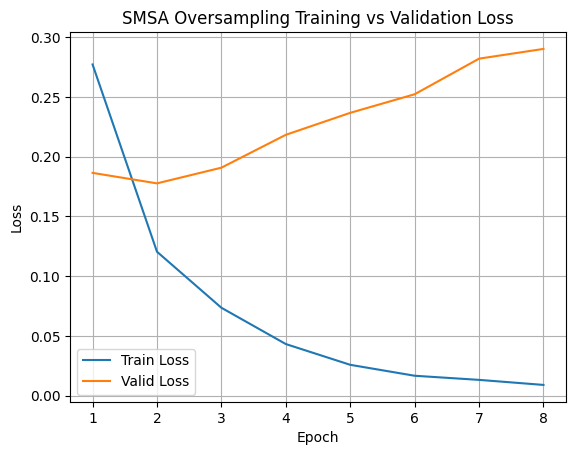

In [111]:
epochs = range(1, 9)
plt.plot(epochs, os_train_losses, label='Train Loss')
# plt.plot(range(1, len(os_train_losses) + 1), os_train_losses, label='Train Loss')
plt.plot(epochs ,os_valid_losses, label='Valid Loss')
# plt.plot(range(1, len(os_valid_losses) + 1), os_valid_losses, label='Valid Loss')
plt.title("SMSA Oversampling Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

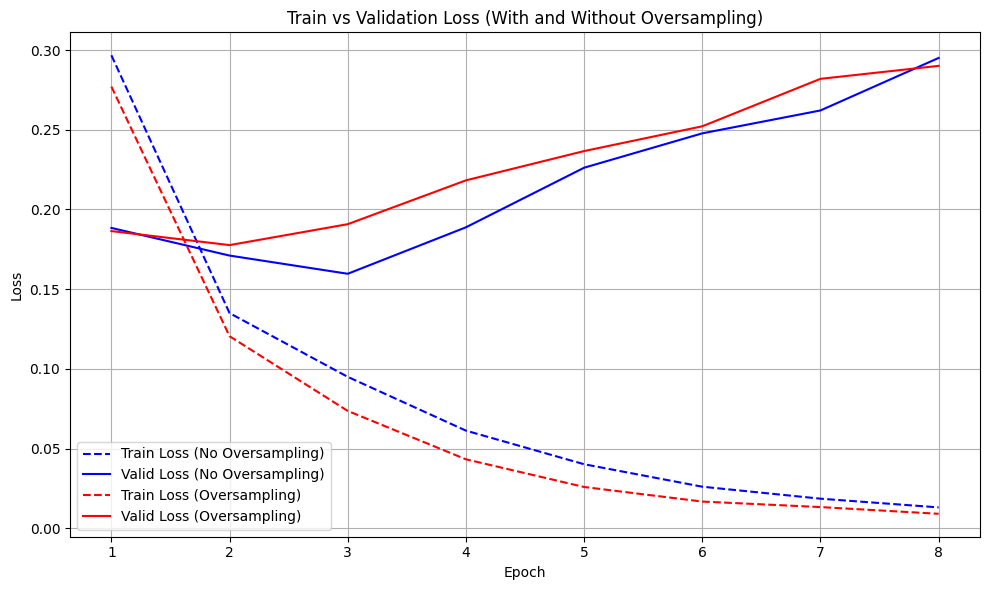

In [109]:
epochs = range(1, 9)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, 'b--', label='Train Loss (No Oversampling)')
plt.plot(epochs, valid_losses, 'b-', label='Valid Loss (No Oversampling)')
plt.plot(epochs, os_train_losses, 'r--', label='Train Loss (Oversampling)')
plt.plot(epochs, os_valid_losses, 'r-', label='Valid Loss (Oversampling)')

plt.title("Train vs Validation Loss (With and Without Oversampling)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [128]:
# Evaluate on test
os_accuracies = []
os_f1_score = []
model_paths = [
    "../backend/model/smsa-oversampling/oversampling-smsa-model-1.pt",
    "../backend/model/smsa-oversampling/oversampling-smsa-model-2.pt",
    "../backend/model/smsa-oversampling/oversampling-smsa-model-3.pt",
    "../backend/model/smsa-oversampling/oversampling-smsa-model-4.pt",
    "../backend/model/smsa-oversampling/oversampling-smsa-model-5.pt",
    "../backend/model/smsa-oversampling/oversampling-smsa-model-6.pt",
    "../backend/model/smsa-oversampling/oversampling-smsa-model-7.pt",
    "../backend/model/smsa-oversampling/oversampling-smsa-model-8.pt"
]

i = 0
for path in model_paths:
    i += 1
    model.load_state_dict(torch.load(path, map_location='cpu'))
    model.eval()
    torch.set_grad_enabled(False)

    list_hyp, list_label = [], []

    pbar = tqdm(test_loader, leave=True, total=len(test_loader))
    for _, batch_data in enumerate(pbar):
        _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cpu')
        list_hyp += batch_hyp
        list_label += batch_label

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    os_accuracies.append(metrics['ACC'])
    os_f1_score.append(metrics['F1'])
    print(f"TEST Matrics {i}", end="")
    print(" | {}".format(metrics_to_string(metrics)))

100%|██████████| 16/16 [00:35<00:00,  2.20s/it]


TEST Matrics 1 | ACC:0.91 F1:0.89 REC:0.87 PRE:0.91


100%|██████████| 16/16 [00:31<00:00,  1.94s/it]


TEST Matrics 2 | ACC:0.91 F1:0.88 REC:0.87 PRE:0.91


100%|██████████| 16/16 [00:32<00:00,  2.05s/it]


TEST Matrics 3 | ACC:0.92 F1:0.89 REC:0.88 PRE:0.92


100%|██████████| 16/16 [00:31<00:00,  1.99s/it]


TEST Matrics 4 | ACC:0.92 F1:0.89 REC:0.87 PRE:0.93


100%|██████████| 16/16 [00:30<00:00,  1.93s/it]


TEST Matrics 5 | ACC:0.93 F1:0.91 REC:0.90 PRE:0.93


100%|██████████| 16/16 [00:32<00:00,  2.03s/it]


TEST Matrics 6 | ACC:0.91 F1:0.88 REC:0.86 PRE:0.92


100%|██████████| 16/16 [00:31<00:00,  1.97s/it]


TEST Matrics 7 | ACC:0.92 F1:0.90 REC:0.89 PRE:0.92


100%|██████████| 16/16 [00:31<00:00,  2.00s/it]

TEST Matrics 8 | ACC:0.92 F1:0.89 REC:0.87 PRE:0.93


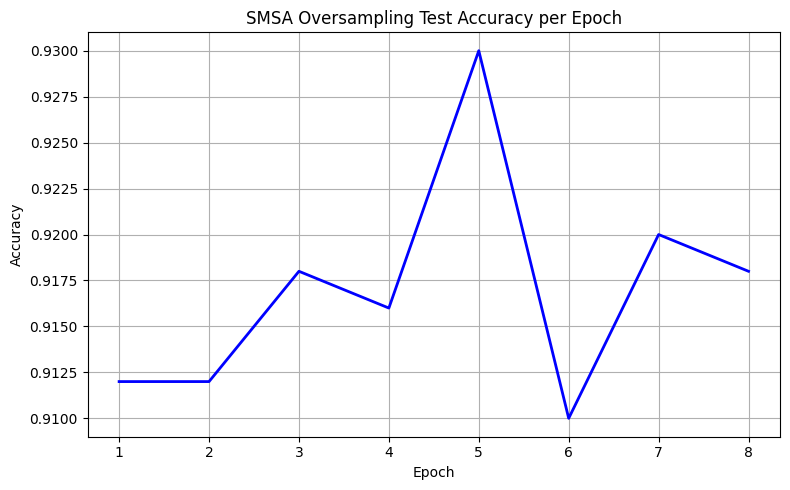

In [129]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(os_accuracies)+1), os_accuracies, color='blue', linewidth=2)  # grafik garis
plt.title("SMSA Oversampling Test Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1, len(os_accuracies)+1))  # biar x axis mulai dari 1
plt.grid(True)
plt.tight_layout()
plt.show()


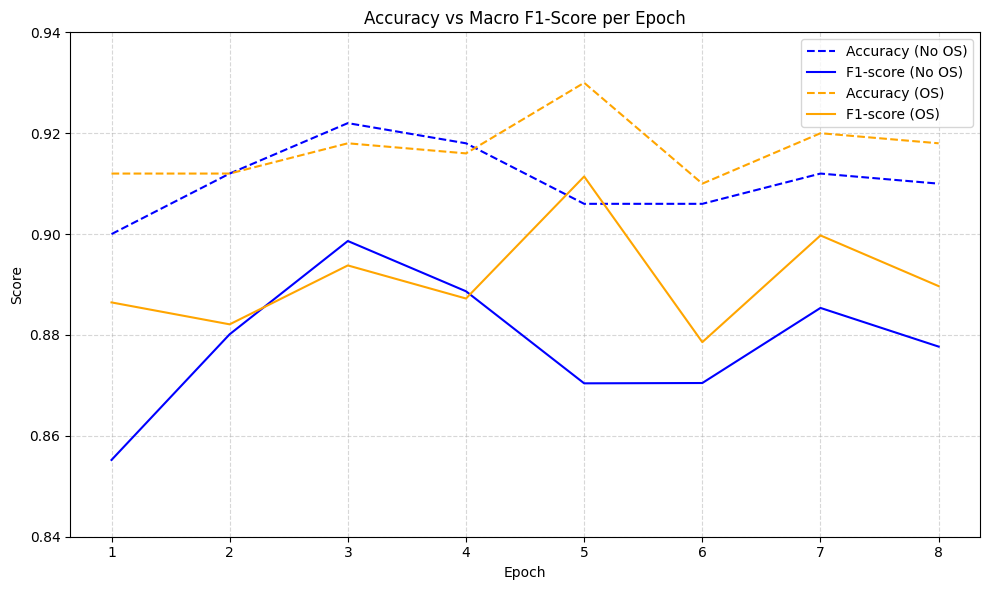

In [134]:
plt.figure(figsize=(10, 6))

epochs = range(1, 9)

plt.plot(epochs, accuracies, 'b--', label='Accuracy (No OS)')
plt.plot(epochs, f1_scores, 'b-', label='F1-score (No OS)')
plt.plot(epochs, os_accuracies, 'orange', linestyle='--', label='Accuracy (OS)')
plt.plot(epochs, os_f1_score, 'orange', linestyle='-', label='F1-score (OS)')

plt.xticks(epochs)
plt.title("Accuracy vs Macro F1-Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.ylim(0.84, 0.94)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### Testing model from .csv file and sample sentences using Epoch 5

In [18]:
# Labeling data
model.load_state_dict(torch.load("../backend/model/smsa-oversampling/oversampling-smsa-model-5.pt", map_location='cpu'))
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_label_loader, leave=True, total=len(test_label_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cpu')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('../data/output/smsa-oversampling/pred.csv', index=False)

df

100%|██████████| 16/16 [00:30<00:00,  1.92s/it]


,index,label
0,0,negative
1,1,negative
2,2,negative
3,3,negative
4,4,negative
...,...,...
495,495,neutral
496,496,neutral
497,497,neutral
498,498,positive


In [19]:
# Combine and compare with true
print(test_df.columns)

combined_test_df = test_df
combined_test_df['sentiment'] = combined_test_df['sentiment'].apply(lambda lab: i2w[lab])
combined_test_df['label'] = df['label'].values
combined_test_df.to_csv('../data/output/smsa-oversampling/combined-test-label.csv', index=False)

Index(['text', 'sentiment'], dtype='object')


In [20]:
combined_test_df = pd.read_csv('../data/output/smsa-oversampling/combined-test-label.csv', header=0)
combined_test_df

,text,sentiment,label
0,kemarin gue datang ke tempat makan baru yang a...,negative,negative
1,kayak nya sih gue tidak akan mau balik lagi ke...,negative,negative
2,"kalau dipikir-pikir , sebenarnya tidak ada yan...",negative,negative
3,ini pertama kalinya gua ke bank buat ngurusin ...,negative,negative
4,waktu sampai dengan gue pernah disuruh ibu lat...,negative,negative
...,...,...,...
495,kata nya tidur yang baik itu minimal enam jam ...,neutral,neutral
496,indonesia itu ada di benua asia .,neutral,neutral
497,salah satu kegemaran anak remaja indonesia sek...,neutral,neutral
498,melihat warna hijau bisa bikin mata jadi lebih...,positive,positive


              precision    recall  f1-score   support

    positive       0.92      1.00      0.96       204
     neutral       0.92      0.77      0.84        88
    negative       0.95      0.93      0.94       208

    accuracy                           0.93       500
   macro avg       0.93      0.90      0.91       500
weighted avg       0.93      0.93      0.93       500



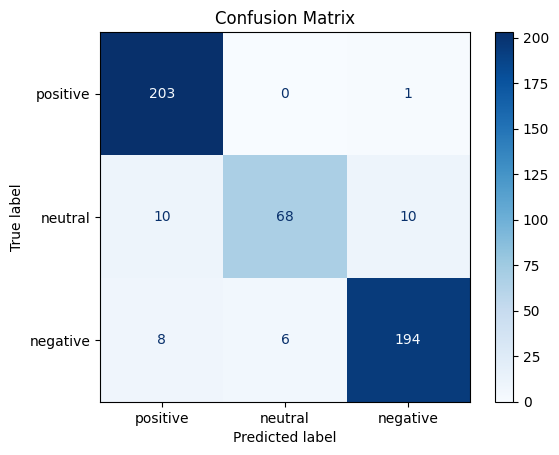

In [21]:
y_true = combined_test_df['sentiment'].tolist()
y_pred = combined_test_df['label'].tolist()

print(classification_report(y_true, y_pred, target_names=INDEX2LABEL.values()))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=INDEX2LABEL.values())
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [22]:
model.load_state_dict(torch.load("../backend/model/smsa-oversampling/oversampling-smsa-model-3.pt", map_location='cpu'))
model.eval()
torch.set_grad_enabled(False)

In [23]:
text = 'bagus banget fotonya itu'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bagus banget fotonya itu | Label : positive (99.509%)


In [26]:
text = 'pagi tadi pergi ke BLI'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: pagi tadi pergi ke BLI | Label : neutral (99.781%)


In [27]:
text = 'Dasar anak sialan!! Kurang ajar!!'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Dasar anak sialan!! Kurang ajar!! | Label : negative (99.708%)


In [36]:
text = 'Pengiriman cepat sesuai tgl prediksi pada keterangan, alat berfungsi, saya bingung untuk standeenya dapet darimana dan gimana sistem garansinya karna di dlm box ga ada kartu garansinya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Pengiriman cepat sesuai tgl prediksi pada keterangan, alat berfungsi, saya bingung untuk standeenya dapet darimana dan gimana sistem garansinya karna di dlm box ga ada kartu garansinya | Label : negative (96.633%)


### Prepare Lazada's reviews dataset

DO NOT RUN THIS SCRIPT AGAIN!!!

In [14]:
# Testing with Lazada Indonesian Reviews
lazada_reviews_path = '../data/lazada_reviews/lazada-reviews-without-sentiment.csv'

# Remove unused columns and remove missing values
lazada_df = pd.read_csv(lazada_reviews_path, header=None, low_memory=False)
lazada_df.columns = lazada_df.iloc[0]
lazada_df = lazada_df[1:]
lazada_df = lazada_df.reset_index(drop=True)
lazada_df = lazada_df[['reviewContent']].rename(columns={'reviewContent': 'text'})
lazada_df = lazada_df.dropna()
lazada_df['sentiment'] = 'isi ini ya ges (positive/neutral/negative)'

sample_df = lazada_df.sample(n=11000, random_state=42).reset_index(drop=True)
sample_df.to_csv('../data/lazada_reviews/train-lazada.csv')

In [ ]:
remaining_df = lazada_df[~lazada_df['text'].isin(sample_df['text'])]

test_df = remaining_df.sample(n=500, random_state=99).reset_index(drop=True)
test_df.to_csv('../data/lazada_reviews/test-lazada.csv')

In [ ]:
used_texts = set(sample_df['text']) | set(test_df['text'])

new_remaining_df = lazada_df[~lazada_df['text'].isin(used_texts)]

valid_df = remaining_df.sample(n=1260, random_state=123).reset_index(drop=True)
valid_df.to_csv('../data/lazada_reviews/valid-lazada.csv')

valid_df

YOU CAN RUN AFTER THIS

In [17]:
lazada_train_dataset_path = '../data/lazada_reviews/train-lazada.csv'
lazada_valid_dataset_path = '../data/lazada_reviews/valid-lazada.csv'
lazada_test_dataset_path = '../data/lazada_reviews/test-lazada.csv'
# lazada_test_labeling_path = '../data/smsa/test.csv'

In [18]:
def load_dataset_csv(path):
    df = pd.read_csv(path, header=0)
    # df.columns = ['text', 'sentiment']
    df['sentiment'] = 'neutral'
    df['sentiment'] = df['sentiment'].apply(lambda lab: LABEL2INDEX[lab])
    return df

def load_dataset_empty(path):
    df = pd.read_csv(path)
    df['sentiment'] = 'neutral'
    return df

In [32]:
lazada_train_df = load_dataset_csv(lazada_train_dataset_path)
lazada_train_df = lazada_train_df.drop(columns=['Unnamed: 0'])
lazada_valid_df = load_dataset_csv(lazada_valid_dataset_path)
lazada_valid_df = lazada_valid_df.drop(columns=['Unnamed: 0'])
lazada_test_df  = load_dataset_csv(lazada_test_dataset_path)
lazada_test_df = lazada_test_df.drop(columns=['Unnamed: 0'])
# test_label_df = load_dataset(lazada_test_labeling_path)

In [33]:
lazada_train_encoded = encode_dataset(lazada_train_df, tokenizer)
lazada_valid_encoded = encode_dataset(lazada_valid_df, tokenizer)
lazada_test_encoded  = encode_dataset(lazada_test_df, tokenizer)
# lazada_test_label_encoded = encode_dataset(lazada_test_label_df, tokenizer)

In [34]:
lazada_test_df

,text,sentiment
0,barang diterima dlm keadaan kypet tidak berfun...,1
1,kualitas fungsi barang oke,1
2,SESUAI PESANAN,1
3,pengiriman lama sekali dioper2 oleh ninja expr...,1
4,Barang bagus. Original dengan harga miring. Th...,1
...,...,...
495,"awal nya sih senang uda datang hardisk ini, eh...",1
496,mantuuuuuuuuul beli 3biji pecah satu.. tapi ko...,1
497,oke banget...thx,1
498,Polytron dari dulu terkenal bagus dalam produk...,1


In [35]:
lazada_train_label_loader = DataLoader(
    lazada_train_encoded, batch_size=32, shuffle=False, num_workers=8,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

lazada_valid_label_loader = DataLoader(
    lazada_valid_encoded, batch_size=32, shuffle=False, num_workers=8,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

lazada_test_label_loader = DataLoader(
    lazada_test_encoded, batch_size=32, shuffle=False, num_workers=8,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

In [41]:
# Test Lazada's
# Labeling data
model.load_state_dict(torch.load("../backend/model/smsa-model.pt", map_location='cpu'))
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label, list_text = [], [], []

pbar = tqdm(lazada_test_label_loader, leave=True, total=len(lazada_test_label_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cpu')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'text':lazada_test_df['text'], 'label':list_hyp})
df.to_csv('../data/output/lazada-test.csv', index=False)

100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


In [42]:
df

,text,label
0,barang diterima dlm keadaan kypet tidak berfun...,negative
1,kualitas fungsi barang oke,positive
2,SESUAI PESANAN,positive
3,pengiriman lama sekali dioper2 oleh ninja expr...,negative
4,Barang bagus. Original dengan harga miring. Th...,positive
...,...,...
495,"awal nya sih senang uda datang hardisk ini, eh...",positive
496,mantuuuuuuuuul beli 3biji pecah satu.. tapi ko...,negative
497,oke banget...thx,positive
498,Polytron dari dulu terkenal bagus dalam produk...,positive


In [43]:
lazada_test_df

,text,sentiment
0,barang diterima dlm keadaan kypet tidak berfun...,1
1,kualitas fungsi barang oke,1
2,SESUAI PESANAN,1
3,pengiriman lama sekali dioper2 oleh ninja expr...,1
4,Barang bagus. Original dengan harga miring. Th...,1
...,...,...
495,"awal nya sih senang uda datang hardisk ini, eh...",1
496,mantuuuuuuuuul beli 3biji pecah satu.. tapi ko...,1
497,oke banget...thx,1
498,Polytron dari dulu terkenal bagus dalam produk...,1
